# Hyper Spectral Anomaly Detection
## Image Data Tutorial

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

path = "../"
sys.path.append(path)
from sklearn.preprocessing import MaxAbsScaler
import matplotlib.image as mpimg

from PIL import Image
from loguru import logger
import Model as hsa_model
import DataSet as hsa_dataset
import Viz as hsa_viz
from torch.utils.data import DataLoader

logger.remove()
logger.add(sink=f"HSA_log.log", level="CRITICAL")
import MultiFilter as hsa_multifilter

## Image 
Read Images and plot shape of np.array associated with it. 

In [ ]:
image_path = "./night_sky.jpeg"
img = Image.open(image_path)
array = np.array(img)
print(f"array shape: {array.shape}")

array shape: (1280, 1280, 3)


Plot images of the RGB spectra and original data as np before conversion to df. 

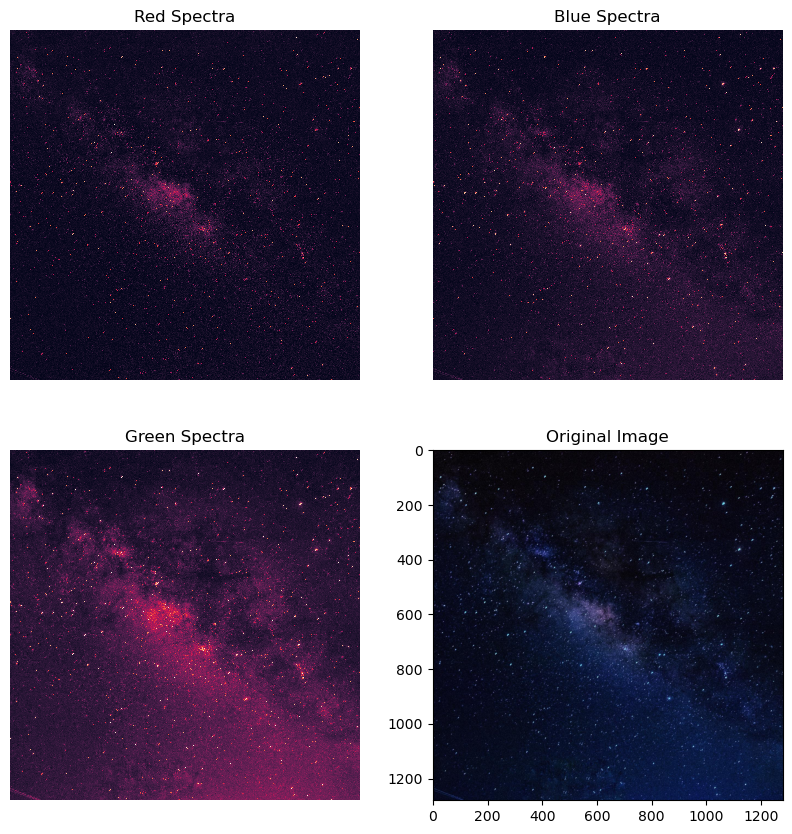

In [3]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
titles = ["Red Spectra", "Blue Spectra", "Green Spectra", "Original Image"]
for i, ax in enumerate(axs.flat):
    try:
        sns.heatmap(
            array[:, :, i],
            square=True,
            xticklabels=False,
            yticklabels=False,
            cbar=False,
            ax=ax,
        )
        ax.set_title(titles[i])
    except:
        ax.set_title(titles[i])
        image = mpimg.imread(image_path)
        ax.imshow(image)

Generate a list of data points from image and convert to df to begin vanilla preprocessing.

In [4]:
data = None
columns = ["red", "green", "blue"]

for row in range(len(array)):
    try:
        data = np.append(data, array[row, :, :], axis=0)
    except:
        data = array[row, :, :]

scaler = MaxAbsScaler()
scaler.fit(data)
preprocessed_df = pd.DataFrame(scaler.transform(data), columns=columns)

## Instantiate
Instantiate the model and dataloader with preprocessed data as a np.array()

In [5]:
anomaly_std_tolerance = 1.2
penalty_ratio = 0.99
cutoff_distance = 1
converge_toll=1e-5,

model = hsa_model.HSA_model(
    penalty_ratio = penalty_ratio,
    cutoff_distance = cutoff_distance,
    converge_toll = converge_toll,
    anomaly_std_tolerance = anomaly_std_tolerance,
    logger=logger,
    affinity_matrix_iterations = 20,
    lr = 2.7,
    multifilter_flag = 0,
)
dataset = hsa_dataset.HSA_dataset(
    preprocessed_np=preprocessed_df.to_numpy(), logger=logger
)
dataloader = DataLoader(dataset, batch_size=100)

## "Train" 
Train model on preprocessed image data.

In [ ]:
base_directory = "Images/"
log_directory = f"{base_directory}/logs/"
results_directory = f"{base_directory}/results/"
model.set_directories(log_directory, results_directory)

model.preprocessed_df = preprocessed_df

logger.info("Starting to run through the dataloader on initial pass.")
unique_id_str = "test"
batch_size = 1000
iterations = 10000

for i, data in enumerate(dataloader):  # setting up gpus
    model.set_trial(i * batch_size, batch_size, unique_id_str)

    # Model set up and weight generation
    model.read_data(
        data_multifilter_df=data.squeeze(0)
    ).vertex_weights_distances().weight_generation().graph_evolution()

    model.train(iterations=iterations)
    model.infer(preprocessed_df)

    # Store anomalous predictions throughout all batches for use in multi filter
    try:
        total_anomaly_index = np.append(total_anomaly_index, model.anomaly_index_raw)
    except:
        total_anomaly_index = model.anomaly_index_raw
    if i >100:
        break
    

0


Collect $1^{st}$ rank anomalies for later use in the Multifilter. Non-anomalous data is collected from all data such that anomalies and non-anomalous data compose $\%10$ and $\%90$ respectively.

In [8]:
mix_index, mix_data, anomaly_index = model.global_collect_multifilter_df(
    preprocessed_df.to_numpy(),
    total_anomaly_index[: len(preprocessed_df.to_numpy())].astype(int),
    mf_batch_size=9 * len(total_anomaly_index),
)
anomaly_prediction_frequency_df = model.apf_df_generation(anomaly_index)

Shuffle data so that the blocks of anomalous and non- anomalous data are randomly distributed throughout the multifilter dataset. 

In [9]:
model.uni_shuffle_multifilter_df(
    mix_index.astype(int), mix_data.astype(int), anomaly_index.astype(int)
)
mf_data = model.all_data
logger.debug("Anomalous data has been colleted into first multifilter dataset.")

In [ ]:
print(
    f"Original data input - preprocessed_df: {preprocessed_df.shape} \nFirst rank anomalous predictions - anomaly_prediction_frequency_df:{anomaly_prediction_frequency_df.shape} \nMultifilter data shape - mf_data: {mf_data.shape}, {type(mf_data)}"
)

Original data input- preprocessed_df: (1638400, 3) 
First rank anomlus predictions- anomaly_prediction_frequency_df:(3071, 2) 
Multifilter data shape- mf_data: (30710, 3), <class 'numpy.ndarray'>


## Multifilter
Instantiating a multifilter based off of the first pass model's hyper parameters. After the model has predicted on the multifilter data set thirty times, an updated anomaly_prediction_frequency_df is returned.

In [ ]:
multi_filters = 30
all_index_user = model.all_index_user
MF_model, anomaly_prediction_frequency_df = hsa_multifilter.multifilter(
    multi_filters,
    batch_size,
    penalty_ratio,
    cutoff_distance,
    anomaly_std_tolerance,
    mf_data,
    all_index_user,
    model,
)
display(anomaly_prediction_frequency_df.head(5))

## Visualization 
The HSA_viz class is used to consistently inspect the model's preprocessed input data, model scores, and multifilter prediction frequency. 

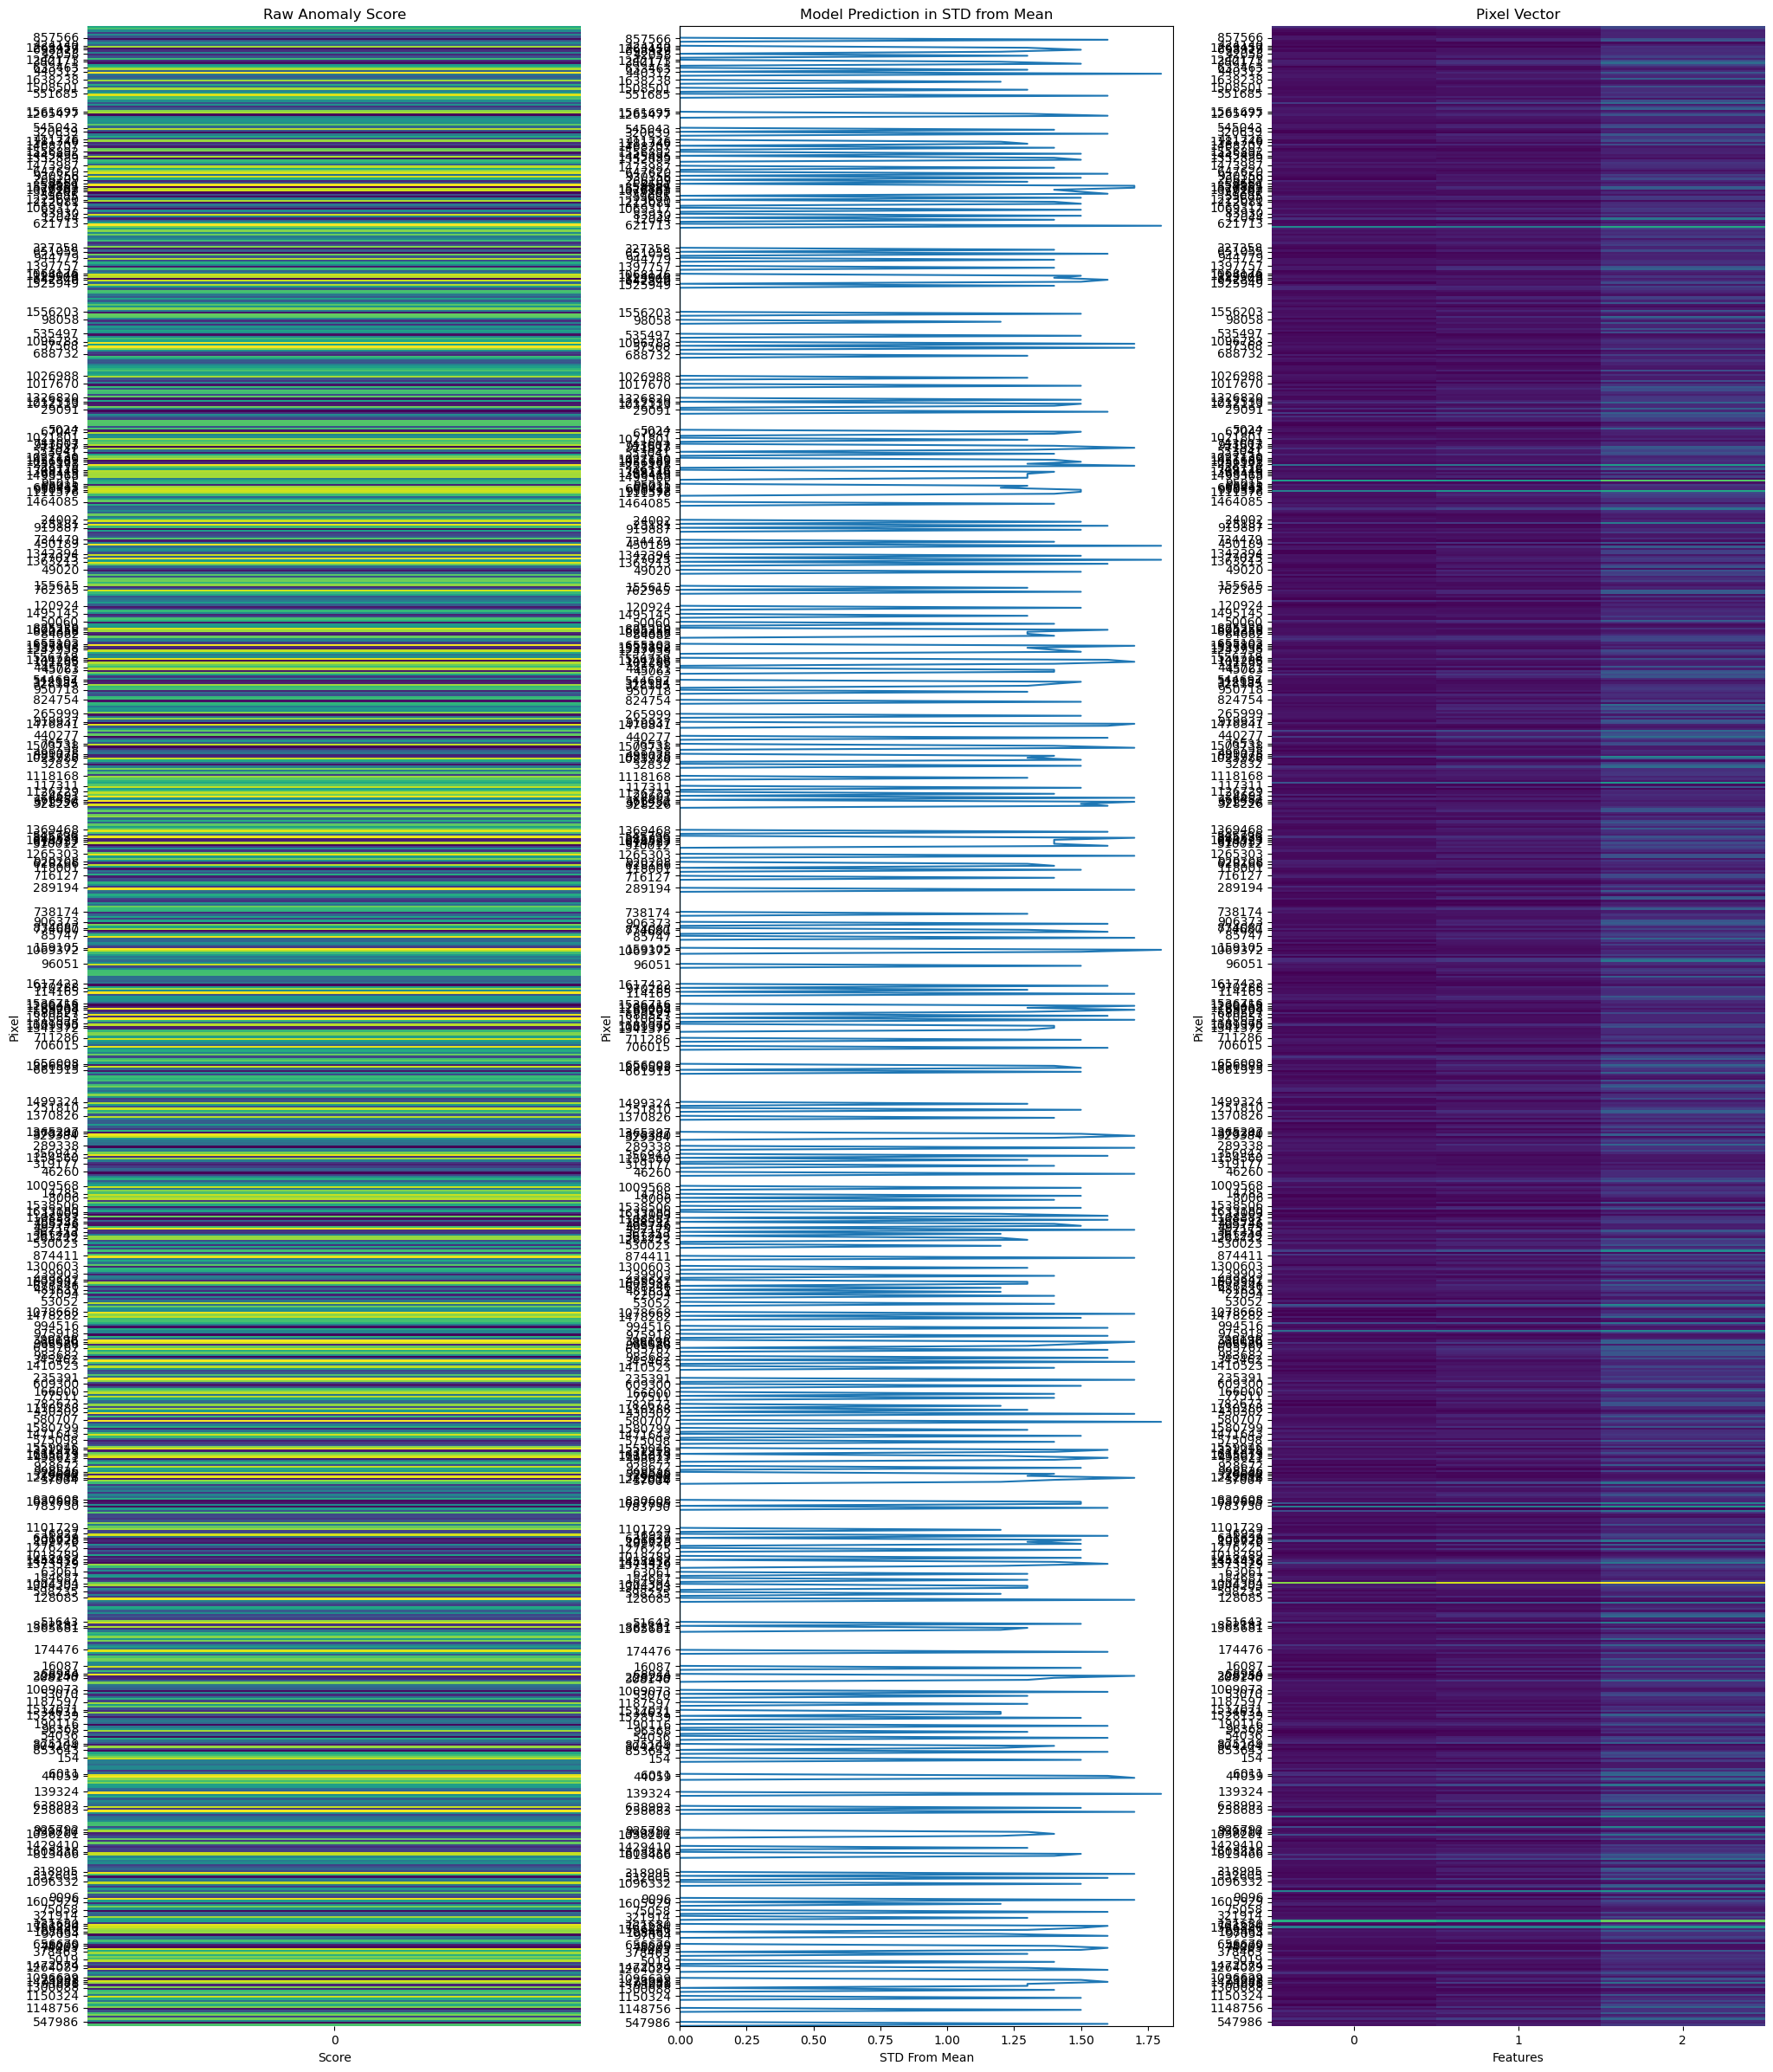

In [12]:
viz = hsa_viz.HSA_viz(
    MF_model.m,
    MF_model.preprocessed_np,
    batch_size,
    0,
    0,
    1,
    0,
    "plot_directory",
    "unique_id_str",
    logger,
)
viz.heatmap_bin_predictions_vert(
    MF_model.bin_score,
    MF_model.anomalous_location,
    MF_model.anomaly_index_raw,
)


Insert non-zero multifilter frequency of predictions to preprocessed_df to visualize model predictions. 

In [13]:
preprocessed_df["Anomaly Bin Count"] = np.zeros(len(preprocessed_df))
for i in anomaly_prediction_frequency_df[
    anomaly_prediction_frequency_df["Anomaly Bin Count"] > 0
].index:
    preprocessed_df.loc[anomaly_prediction_frequency_df.loc[i], "Anomaly Bin Count"] = (
        anomaly_prediction_frequency_df.loc[i, "Anomaly Bin Count"]
    )

Restore data and predictions to original image dimensions. 

In [14]:
image_width = 1280
anomaly_score_np = []
for i in range(int(len(preprocessed_df) / image_width)):
    anomaly_score_np.append(
        preprocessed_df["Anomaly Bin Count"][i * image_width : (1 + i) * image_width]
    )

## Comparison between model predictions and raw data. 

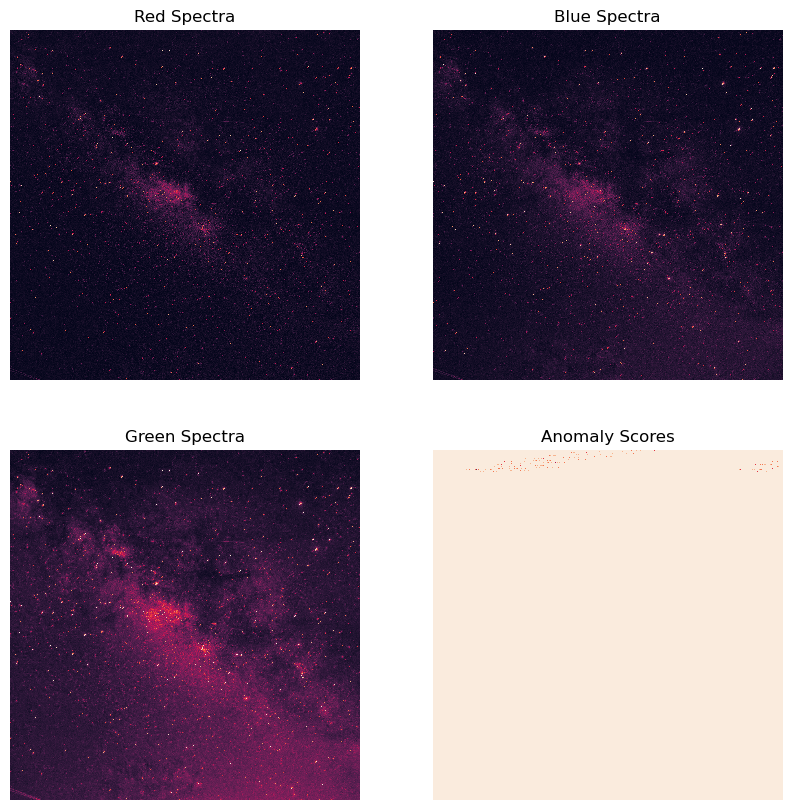

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
titles = ["Red Spectra", "Blue Spectra", "Green Spectra", "Anomaly Scores"]
for i, ax in enumerate(axs.flat):
    try:
        sns.heatmap(
            array[:, :, i],
            square=True,
            xticklabels=False,
            yticklabels=False,
            cbar=False,
            ax=ax,
        )
        ax.set_title(titles[i])
    except:
        ax.set_title(titles[i])
        sns.heatmap(
            anomaly_score_np,
            square=True,
            xticklabels=False,
            yticklabels=False,
            cbar=False,
            ax=ax,
            cmap="rocket_r",
        )

Model prediction statistics.

Max anomaly score: 7.0
Number of Anomalies:  1851


<Axes: xlabel='Anomaly Bin Count', ylabel='Count'>

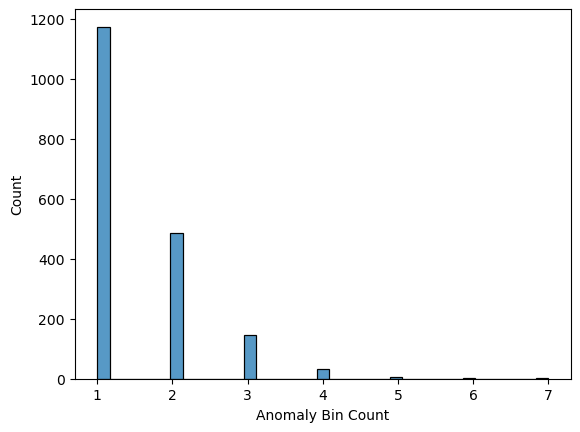

In [16]:
print(f"Max anomaly score: {np.array(anomaly_score_np).max()}")
print(f"Number of Anomalies:  {np.sum(np.greater(np.array(anomaly_score_np), 0))}")
sns.histplot(
    preprocessed_df.loc[preprocessed_df["Anomaly Bin Count"] > 0]["Anomaly Bin Count"]
)